In [4]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
from sklearn.preprocessing import OneHotEncoder

In [5]:
diets = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\diets.csv')
medications = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\medications.csv')
precautions = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\precautions_df.csv')
symptom_severity = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\Symptom-severity.csv')
symptoms = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\symtoms_df.csv')
workouts = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\workout_df.csv')



In [ ]:
# Prepare symptoms data
symptoms_long = symptoms.melt(id_vars=['Disease'], value_vars=[f'Symptom_{i}' for i in range(1, 5)], var_name='SymptomType', value_name='Symptom')
symptoms_severity = pd.merge(symptoms_long, symptom_severity, on='Symptom')


In [7]:
# One-hot encode symptoms
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_symptoms = encoder.fit_transform(symptoms_severity[['Symptom']])
encoded_symptoms_df = pd.DataFrame(encoded_symptoms, columns=encoder.get_feature_names_out(['Symptom']))
symptoms_severity_encoded = pd.concat([symptoms_severity.drop(['Symptom'], axis=1), encoded_symptoms_df], axis=1)

In [8]:
# Define custom healthcare environment class
class HealthcareEnv(gym.Env):
    def __init__(self):
        super(HealthcareEnv, self).__init__()

        # Define action space: actions based on treatments (diets, medications, workouts, precautions)
        self.n_actions = len(diets) + len(medications) + len(workouts)
        self.action_space = spaces.Discrete(self.n_actions)

        # Define observation space (features from the encoded symptom severity data)
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(symptoms_severity_encoded.columns),), dtype=np.float32)

        # Initialize state (random initial state based on symptoms severity)
        self.state = symptoms_severity_encoded.sample(1).iloc[0].values
        self.done = False

    def reset(self):
        # Reset the state to a new random sample of symptom severities
        self.state = symptoms_severity_encoded.sample(1).iloc[0].values
        self.done = False
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        # Simplified logic: reduce severity based on action (could be expanded)
        if action < len(diets):  # Diet action
            self.state = np.clip(self.state - np.random.rand(len(self.state)) * 0.1, 0, 1)
        elif action < len(diets) + len(medications):  # Medication action
            self.state = np.clip(self.state - np.random.rand(len(self.state)) * 0.2, 0, 1)
        else:  # Workout action
            self.state = np.clip(self.state - np.random.rand(len(self.state)) * 0.15, 0, 1)

        # Reward: lower symptom severity should give a higher reward
        reward = -np.sum(self.state)

        # End the episode if all symptoms are near zero (treatment success)
        self.done = np.all(self.state < 0.1)

        return np.array(self.state, dtype=np.float32), reward, self.done, {}

    def render(self, mode='human'):
        print(f"Current symptom severities: {self.state}")



In [9]:
# Initialize the healthcare environment
env = HealthcareEnv()


In [10]:
# Initialize the PPO model and start training
model = PPO('MlpPolicy', env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\himan\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [11]:
from sklearn.preprocessing import LabelEncoder

# Assuming your state has a categorical column like 'disease'
label_encoder = LabelEncoder()

# Fit and transform the disease column
symptoms_severity_encoded['Disease'] = label_encoder.fit_transform(symptoms_severity_encoded['Disease'])


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv  # Corrected import
from sklearn.preprocessing import MultiLabelBinarizer
import gym

# Load your data
symptoms_df = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\symtoms_df.csv')

# Check for any leading/trailing spaces in column names
symptoms_df.columns = symptoms_df.columns.str.strip()

# Preprocess the symptoms: convert symptom columns to lists of symptoms
symptoms_df['symptoms'] = symptoms_df[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']].apply(lambda x: [s.strip() for s in x.tolist() if isinstance(s, str)], axis=1)

# One-hot encode the symptoms using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
symptom_encoded = mlb.fit_transform(symptoms_df['symptoms'])

# Create a new DataFrame with encoded symptoms
encoded_symptoms_df = pd.DataFrame(symptom_encoded, columns=mlb.classes_)

# Concatenate encoded symptoms with the disease column
final_data = pd.concat([symptoms_df[['Disease']], encoded_symptoms_df], axis=1)

# Print the final data to verify encoding
print(final_data)

# Define the custom environment
class HealthcareEnv(gym.Env):
    def __init__(self):
        super(HealthcareEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Example: Two possible actions
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(encoded_symptoms_df.shape[1],), dtype=np.float32)
        self.state = None
        self.done = False

    def reset(self):
        # Sample a random state (numeric representation)
        self.state = encoded_symptoms_df.sample(1).values.flatten()  # Flatten to 1D array
        self.done = False
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        # Your logic to determine the next state and reward goes here
        reward = 1 if action == 1 else -1  # Example: reward based on the action
        self.done = True  # End the episode after one step
        return self.state, reward, self.done, {}

# Create the environment
env = DummyVecEnv([lambda: HealthcareEnv()])

# Initialize the PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model for 10,000 timesteps
model.learn(total_timesteps=10000)


                                      Disease  abdominal_pain  acidity  \
0                            Fungal infection               0        0   
1                            Fungal infection               0        0   
2                            Fungal infection               0        0   
3                            Fungal infection               0        0   
4                            Fungal infection               0        0   
...                                       ...             ...      ...   
4915  (vertigo) Paroymsal  Positional Vertigo               0        0   
4916                                     Acne               0        0   
4917                  Urinary tract infection               0        0   
4918                                Psoriasis               0        0   
4919                                 Impetigo               0        0   

      altered_sensorium  anxiety  back_pain  blackheads  bladder_discomfort  \
0                     0        0

C:\Users\himan\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 773  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 630       |
|    iterations           | 2         |
|    time_elapsed         | 6         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0857916 |
|    clip_fraction        | 0.859     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.626    |
|    explained_variance   | -0.0993   |
|    learning_rate        | 0.0003    |
|    loss                 | 0.293     |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.17     |
|    value_loss           | 0.998     |
---------------------------------------
--------------------------------------
| time/                   |    

In [14]:
# Train the model for 10,000 timesteps
model.learn(total_timesteps=10000)


-----------------------------
| time/              |      |
|    fps             | 877  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 681       |
|    iterations           | 2         |
|    time_elapsed         | 6         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.004    |
|    explained_variance   | nan       |
|    learning_rate        | 0.0003    |
|    loss                 | 0.000562  |
|    n_updates            | 60        |
|    policy_gradient_loss | -4.39e-06 |
|    value_loss           | 0.000993  |
---------------------------------------
------------------------------------------
| time/                   |

In [15]:
# Test the model with 10 steps
state = env.reset()
for _ in range(10):
    action, _states = model.predict(state)
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}")
    if done:
        state = env.reset()
    else:
        state = next_state

Action: [1], Next State: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], Reward: [1.]
Action: [1], Next State: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], Reward: [1.]
Action: [1], Next State: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], Reward: [1.]
Action: [1], Next State: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [16]:
# Save the trained model
model.save("healthcare_recommendation_model")

AttributeError: module 'stable_baselines3' has no attribute '__version__'

In [17]:
# Load and test the saved model
model = PPO.load("healthcare_recommendation_model")

In [18]:
# Test again after loading the model
state = env.reset()
for _ in range(10):
    action, _states = model.predict(state)
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}")
    if done:
        state = env.reset()
    else:
        state = next_state

Action: [1], Next State: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Reward: [1.]
Action: [1], Next State: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], Reward: [1.]
Action: [1], Next State: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]], Reward: [1.]
Action: [1], Next State: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [36]:
def get_health_recommendation():
    # Ask the user for their symptoms
    print("Please enter your symptoms (comma-separated):")
    user_input = input()
    
    # Preprocess the input to match the expected format
    user_symptoms = [symptom.strip() for symptom in user_input.split(",")]
    
    # Create a DataFrame to hold the user's symptoms
    user_symptoms_df = pd.DataFrame(columns=mlb.classes_)
    user_symptoms_df.loc[0] = mlb.transform([user_symptoms])[0]

    # Set the environment state to the user's symptoms
    env.state = user_symptoms_df.values.flatten()
    
    # Use the model to predict the best action
    action, _ = model.predict(env.state)
    
    # Interpret the action
    if action < len(diets):
        recommendation_type = "Diet"
        diet_list = eval(diets.iloc[action]['Diet'])  # Convert string representation of list to actual list
        recommendation = ", ".join(diet_list)  # Join the diets into a string for display
    elif action < len(diets) + len(medications):
        recommendation_type = "Medication"
        recommendation = medications.iloc[action - len(diets)]['Correct_Column_Name']  # Replace with actual column name
    else:
        recommendation_type = "Workout"
        recommendation = workouts.iloc[action - len(diets) - len(medications)]['Correct_Column_Name']  # Replace with actual column name

    # Print the recommendation
    print(f"We recommend the following {recommendation_type}: {recommendation}")

# Run the recommendation function
get_health_recommendation()

Please enter your symptoms (comma-separated):


 chills, shivering


We recommend the following Diet: Elimination Diet, Omega-3-rich foods, Vitamin C-rich foods, Quercetin-rich foods, Probiotics


In [21]:
print(diets.head())  # Display the first few rows of the DataFrame
print(diets.columns)  # Print the names of the columns in the DataFrame

               Disease                                               Diet
0     Fungal infection  ['Antifungal Diet', 'Probiotics', 'Garlic', 'C...
1              Allergy  ['Elimination Diet', 'Omega-3-rich foods', 'Vi...
2                 GERD  ['Low-Acid Diet', 'Fiber-rich foods', 'Ginger'...
3  Chronic cholestasis  ['Low-Fat Diet', 'High-Fiber Diet', 'Lean prot...
4        Drug Reaction  ['Antihistamine Diet', 'Omega-3-rich foods', '...
Index(['Disease', 'Diet'], dtype='object')


C:\Users\himan\AppData\Local\Temp\ipykernel_3688\1292053972.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_counts.index, y=symptom_counts.values, palette='viridis')


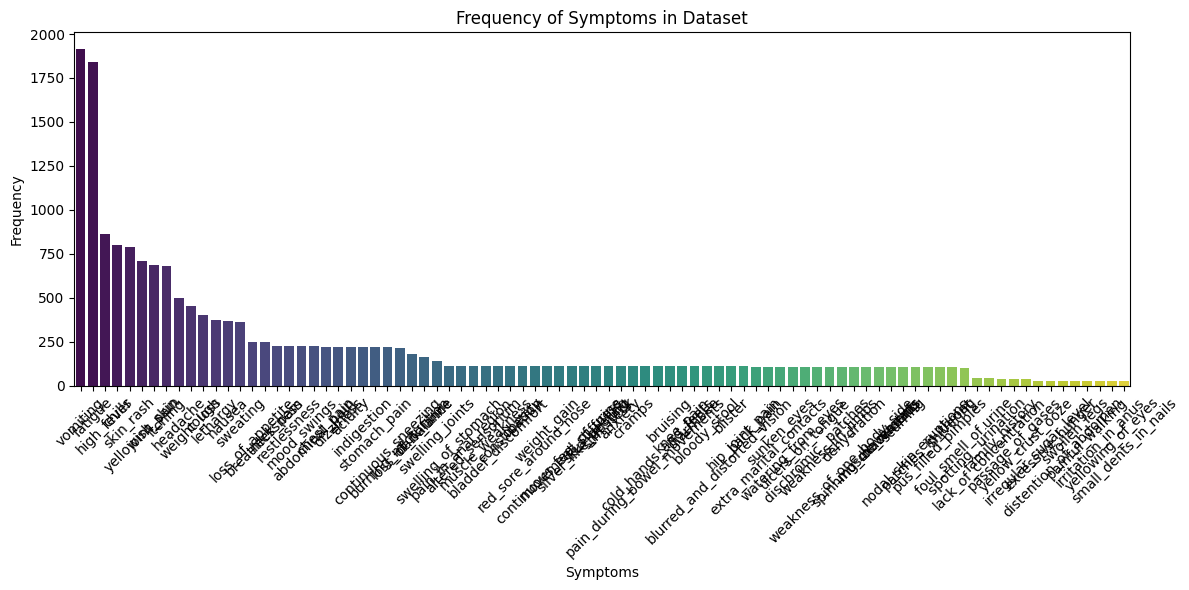

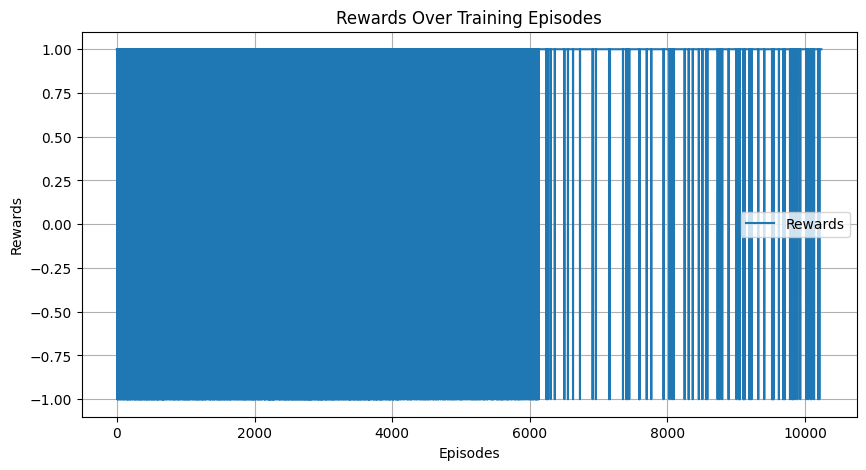

C:\Users\himan\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


KeyError: 'losses'

In [33]:
# Additional imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have your model trained and data processed

# Visualization of symptom distribution
def plot_symptom_distribution(encoded_symptoms_df):
    symptom_counts = encoded_symptoms_df.sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=symptom_counts.index, y=symptom_counts.values, palette='viridis')
    plt.title('Frequency of Symptoms in Dataset')
    plt.xlabel('Symptoms')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example: Function to track and plot rewards (to be called during training)
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(rewards)), rewards, label='Rewards')
    plt.title('Rewards Over Training Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.grid()
    plt.show()

# Example: Function to plot recommendations breakdown
def plot_recommendation_breakdown(action_choices):
    recommendation_counts = pd.Series(action_choices).value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=recommendation_counts.index, y=recommendation_counts.values, palette='coolwarm')
    plt.title('Breakdown of Recommendations')
    plt.xlabel('Recommendations')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1, 2], labels=['Diet', 'Medication', 'Workout'])
    plt.tight_layout()
    plt.show()

# Example: Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Diet', 'Medication', 'Workout'], 
                yticklabels=['Diet', 'Medication', 'Workout'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example: Function to plot loss over time
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(losses)), losses, label='Loss', color='orange')
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting functions after training
# Assuming you have data to pass into these functions
plot_symptom_distribution(encoded_symptoms_df)
plot_rewards(rewards)  # Uncomment when you track rewards
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.preprocessing import MultiLabelBinarizer
import gym
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load your data
symptoms_df = pd.read_csv(r'C:\Users\himan\OneDrive\Desktop\Database ML\symtoms_df.csv')

# Check for any leading/trailing spaces in column names
symptoms_df.columns = symptoms_df.columns.str.strip()

# Preprocess the symptoms: convert symptom columns to lists of symptoms
symptoms_df['symptoms'] = symptoms_df[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']].apply(lambda x: [s.strip() for s in x.tolist() if isinstance(s, str)], axis=1)

# One-hot encode the symptoms using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
symptom_encoded = mlb.fit_transform(symptoms_df['symptoms'])

# Create a new DataFrame with encoded symptoms
encoded_symptoms_df = pd.DataFrame(symptom_encoded, columns=mlb.classes_)

# Define the custom environment
class HealthcareEnv(gym.Env):
    def __init__(self):
        super(HealthcareEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(3)  # Example: Three possible actions
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(encoded_symptoms_df.shape[1],), dtype=np.float32)
        self.state = None
        self.done = False

    def reset(self):
        self.state = encoded_symptoms_df.sample(1).values.flatten()
        self.done = False
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        # Define your reward logic
        reward = 1 if action == 1 else -1  # Example reward structure
        self.done = True  # End the episode after one step
        return self.state, reward, self.done, {}

# Create the environment
env = DummyVecEnv([lambda: HealthcareEnv()])

# Initialize the PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Lists to store rewards, actions, and losses
rewards = []
action_choices = []
losses = []

# Create a custom callback to track rewards and actions
class RewardCallback(BaseCallback):
    def __init__(self):
        super(RewardCallback, self).__init__()

    def _on_step(self) -> bool:
        rewards.append(self.locals['rewards'])  # Collect the rewards
        action_choices.append(self.locals['actions'])  # Collect the actions taken
        losses.append(self.locals['losses'])  # Collect the losses
        return True  # Continue training

# Train the model with the callback
model.learn(total_timesteps=10000, callback=RewardCallback())

# Define the plotting functions
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Rewards', marker='o')
    plt.title('Rewards Over Training Episodes')
    plt.xlabel('Training Steps')
    plt.ylabel('Rewards')
    plt.legend()
    plt.grid()
    plt.show()

def plot_recommendation_breakdown(action_choices):
    plt.figure(figsize=(10, 5))
    plt.hist(action_choices, bins=np.arange(0, 3) - 0.5, density=True, alpha=0.75)
    plt.title('Action Choices Distribution')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.xticks([0, 1, 2])
    plt.grid()
    plt.show()

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Losses', marker='x')
    plt.title('Losses Over Training Episodes')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting functions after training
plot_rewards(rewards)
plot_recommendation_breakdown(action_choices)
plot_loss(losses)

# Confusion matrix placeholder
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Example usage of confusion matrix (you need actual true_labels and predicted_labels for this)
# true_labels = [...]  # Populate this with actual data
# predicted_labels = [...]  # Populate this with model predictions
# plot_confusion_matrix(true_labels, predicted_labels)  # Uncomment with true labels

